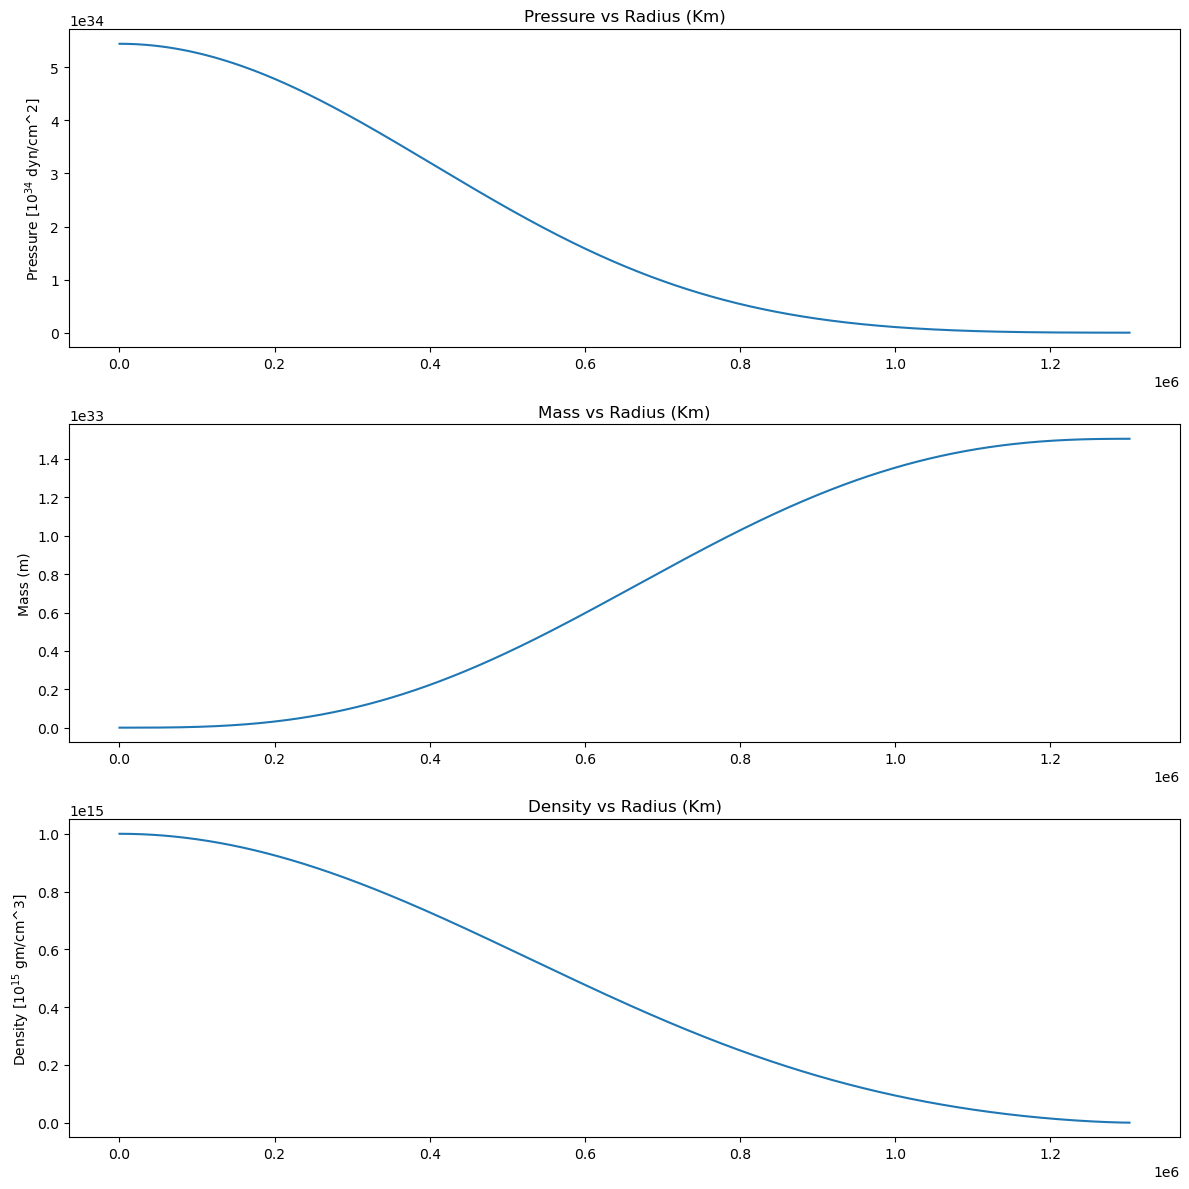

Mass = 1.5052703134157214e+33, Size = 1302310


In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Constants
G = 6.67430e-8
c = 2.99792458e10
pi = 3.14
r0 = 10
h = 100

# Polytropic EOS P=K*rho^gamma
k = 5.38e9
gamma = 1.667

rho_c = 1e15
p0 = k * (rho_c) ** gamma
m0 = (4 / 3) * pi * (r0 ** 3) * rho_c


def rho(r, p):
    if r == r0:
        return rho_c
    else:
        return (p / k) ** (1.0 / gamma)


def dmdr(r, m, p):
    return 4 * pi * (r ** 2) * rho(r, p)


def mrk4(r, m, p, h):
    k1 = h * dmdr(r, m, p)
    k2 = h * dmdr(r + 0.5 * h, m + 0.5 * k1, p)
    k3 = h * dmdr(r + 0.5 * h, m + 0.5 * k2, p)
    k4 = h * dmdr(r + h, m + k3, p)
    mnew = m + (1.0 / 6.0) * (k1 + 2 * k2 + 2 * k3 + k4)
    return mnew


def dpdr(r, p, m):
    try:
        term1 = -((G * m) / (r ** 2))
        term2 = rho(r, p)
        term3 = 1 + (p / (rho(r, p) * (c ** 2)))
        term4 = 1 + (((4 * pi * (r ** 3) * p)) / (m * (c ** 2)))
        term5 = 1 - ((2 * G * m) / (r * (c ** 2)))
        result = (term1 * term2 * term3 * term4) / term5
        if isinstance(result, complex):
            return np.nan
        return result
    except Exception as e:
        print(f"Exception in dpdr: {e}")
        return np.nan


def rk4(r0, p0, m0, h, number):
    r = r0
    p = p0
    m = m0

    r_new = [r0]
    rho_new = [rho_c]
    p_new = [p0]
    m_new = [m0]

    for i in range(number):
        k1 = h * dpdr(r, p, m)
        k2 = h * dpdr(r + 0.5 * h, p + 0.5 * k1, m)
        k3 = h * dpdr(r + 0.5 * h, p + 0.5 * k2, m)
        k4 = h * dpdr(r + h, p + k3, m)

        if np.isnan(k1) or np.isnan(k2) or np.isnan(k3) or np.isnan(k4):
            break

        pnew = p + (1.0 / 6.0) * (k1 + 2 * k2 + 2 * k3 + k4)
        rnew = r + h

        if pnew < 0:  # Exit computation when the surface of the star is encountered
            break

        rhonew = (pnew / k) ** (1.0 / gamma)
        mnew = mrk4(r, m, p, h)

        r = rnew
        p = pnew
        m = mnew

        r_new.append(rnew)
        rho_new.append(rhonew)
        p_new.append(pnew)
        m_new.append(mnew)

    return r_new, rho_new, p_new, m_new

number = 500000
# Run the RK4 integrator
r_new, rho_new, p_new, m_new = rk4(r0, p0, m0, h, number)

# Plotting results
plt.figure(figsize=(12, 12))

plt.subplot(3, 1, 1)
plt.title("Pressure vs Radius (Km)")
plt.plot(r_new, p_new)
plt.ylabel("Pressure [$10^{34}$ dyn/cm^2]")

plt.subplot(3, 1, 2)
plt.title("Mass vs Radius (Km)")
plt.plot(r_new, m_new)
plt.ylabel("Mass (m)")

plt.subplot(3, 1, 3)
plt.title("Density vs Radius (Km)")
plt.plot(r_new, rho_new)
plt.ylabel("Density [$10^{15}$ gm/cm^3]")

plt.tight_layout()
plt.show()

print(f"Mass = {m_new[-1]}, Size = {r_new[-1]}")